<div class="alert alert-success">
    <h1 align="center">Image Classification (herbarium)</h1>
    <h2 align="center">seyed ali alavi</h2>
</div>

 # Objectives

- Image classification
- Four key components of any ML system (in PyTorch):
 - Data (Images)
 - Model
 - Loss (Cross Entropy)
 - Optimization (SGD, Adam, ..)
- Convolutional Neural Networks (CNNs)
- Overfit
- Data augmentation
- Transfer learning

# libraries

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation , Input
from keras.layers import Conv2D, MaxPooling2D, Flatten
from keras.layers import BatchNormalization, Dropout
from keras.utils import to_categorical

import itertools
import shutil
import random
import math
import time
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import tensorflow as tf
from sklearn.metrics import precision_score, recall_score, f1_score
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms


# some initial setup
np.set_printoptions(precision=2)
use_gpu = torch.cuda.is_available()
np.random.seed(1234)


# functions we will use it

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor.
    """
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.axis('off')
    if title is not None:
        plt.title(title)


# accuracy
def evaluate_model(model, dataloader, device):
    model.eval()  # for batch normalization layers
    corrects = 0

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            corrects += (preds == targets.data).sum()

    acc = 100. * corrects / len(dataloader.dataset)
    return acc




# Data


*   train: learning the parameters of the model.
*   valid: learning hyper-parameters.
*   test


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip gdrive/My\Drive/herbarium/small-train.zip

In [ ]:
!unzip gdrive/My\Drive/herbarium/small-validation.zip

In [ ]:
train_dt = '/content/small-train'
valid_dt = '/content/small-validation'

**the largest and smallest number of data in the class**

In [ ]:
# number of the class
num_classes = 683

# A list to store the number of data of each class
class_counts = [0] * num_classes

# Calculate the number of data in each class
for class_name in os.listdir(valid_dt):
    class_id = int(class_name)
    class_path = os.path.join(valid_dt, class_name)
    num_samples = len(os.listdir(class_path))
    class_counts[class_id] = num_samples

# Find the class with the least and the most number of data
min_samples_class = class_counts.index(min(class_counts))
max_samples_class = class_counts.index(max(class_counts))

print(f"The least amount of data: {min(class_counts)}\t In class no: {min_samples_class}")
print(f"Maximum number of data: {max(class_counts)}\t In class no: {max_samples_class}")

The least amount of data: 1	 In class no: 26
Maximum number of data: 44	 In class no: 535


# number of photos in classes with more than 100 photo

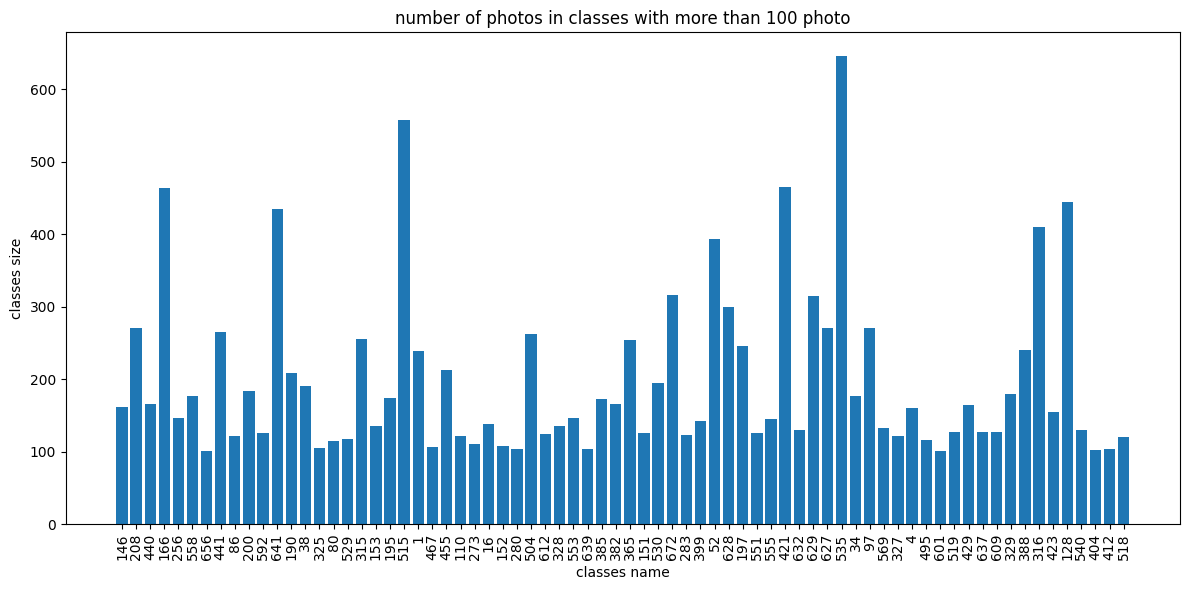

In [ ]:

classes = os.listdir(train_dt)

# Create a dictionary to store the number of photos in each class
class_image_counts = {}

# For each class, calculate the number of photos and store them in the dictionary
for class_name in classes:
    class_path = os.path.join(train_dt, class_name)
    num_images = len(os.listdir(class_path))
    class_image_counts[class_name] = num_images

selected_classes = [class_name for class_name, num_images in class_image_counts.items() if num_images > 100]

# Leave only the number of photos of the selected classes in the dictionary
filtered_counts = {class_name: num_images for class_name, num_images in class_image_counts.items() if class_name in selected_classes}

# Histogram chart
plt.figure(figsize=(12, 6))
plt.bar(filtered_counts.keys(), filtered_counts.values())
plt.xlabel('classes name')
plt.ylabel('classes size')
plt.title('number of photos in classes with more than 100 photo')
plt.xticks(rotation=90)
plt.tight_layout()

# Histogram display
plt.show()


# Just for fun

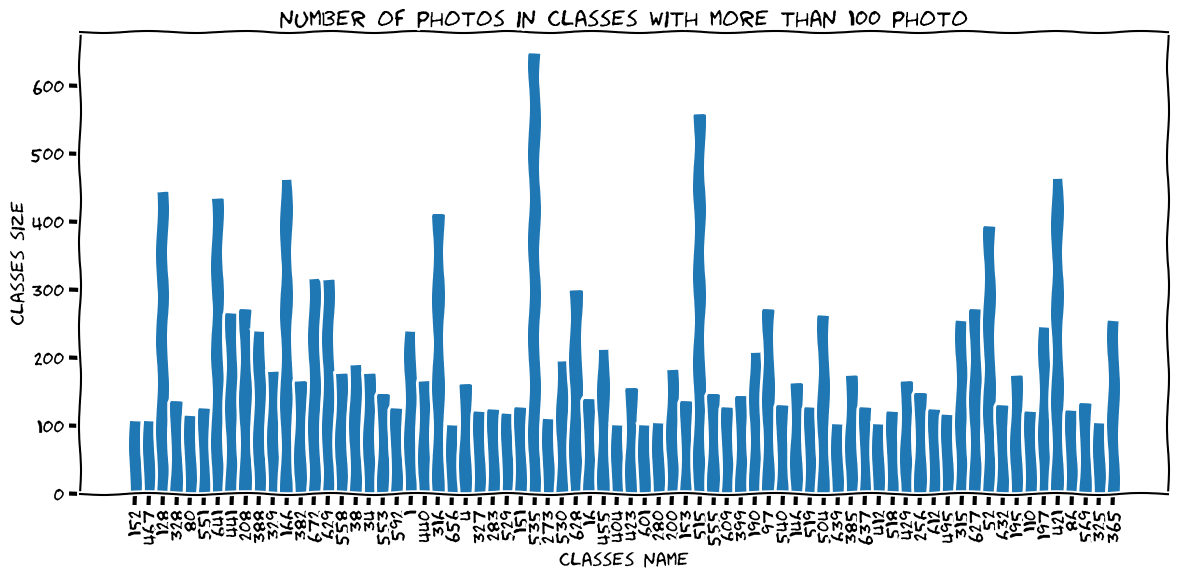

In [ ]:
with plt.xkcd():

  classes = os.listdir(train_dt)

# Create a dictionary to store the number of photos in each class
  class_image_counts = {}

# For each class, calculate the number of photos and store them in the dictionary
  for class_name in classes:
      class_path = os.path.join(train_dt, class_name)
      num_images = len(os.listdir(class_path))
      class_image_counts[class_name] = num_images


  selected_classes = [class_name for class_name, num_images in class_image_counts.items() if num_images > 100]

# Leave only the number of photos of the selected classes in the dictionary
  filtered_counts = {class_name: num_images for class_name, num_images in class_image_counts.items() if class_name in selected_classes}

# Histogram chart
  plt.figure(figsize=(12, 6))
  plt.bar(filtered_counts.keys(), filtered_counts.values())
  plt.xlabel('classes name')
  plt.ylabel('classes size')
  plt.title('number of photos in classes with more than 100 photo')
  plt.xticks(rotation=90)
  plt.tight_layout()

# Histogram display
  plt.show()



#Average number of all classes

In [ ]:
class_image_counts = []

def Avg(data):

    # For each class, count the number of photos and add them to the list
  for class_name in classes:

    class_path = os.path.join(data, class_name)
    num_images = len(os.listdir(class_path))
    class_image_counts.append(num_images)

    # Calculate the number of average shots
    average_image_count = sum(class_image_counts) / len(class_image_counts)
  return  average_image_count

train_avg = Avg(train_dt)
validation_avg = Avg(valid_dt)

print(f"Average number of all train classes: {train_avg:.2f}\n\nAverage number of all train classes: {validation_avg:.2f}")

Average number of all train classes: 50.11

Average number of all train classes: 27.02


# Preprocessing

## Transformations

In [ ]:
sz = 224
tfms = transforms.Compose([
    transforms.Resize((sz, sz)),  # PIL Image
    transforms.ToTensor(),        # Tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# ایجاد دیتالودرها با تبدیل‌های مخصوص هر داده
train_ds = datasets.ImageFolder(train_dt, transform=tfms)
valid_ds = datasets.ImageFolder(valid_dt, transform=tfms)


# Loading the herbarium data

## Dataloaders

*  Dataloader
   
    Loads data from dataset behind the scene using concurrent threads.

In [ ]:
batch_size = 32
train_dl = torch.utils.data.DataLoader(train_ds,
                                       batch_size=batch_size,
                                       shuffle=True,
                                       num_workers=8)

valid_dl = torch.utils.data.DataLoader(valid_ds,
                                       batch_size=batch_size,
                                       shuffle=False,
                                       num_workers=8)


# size of train and validation data

In [ ]:
train_ds_sz = len(train_ds)
valid_ds_sz = len(valid_ds)

print('Train size: {}\nValid size: {} )'.format(train_ds_sz, valid_ds_sz))

class_names = train_ds.classes

Train size: 34225
Valid size: 2679 )


# Random images from training data

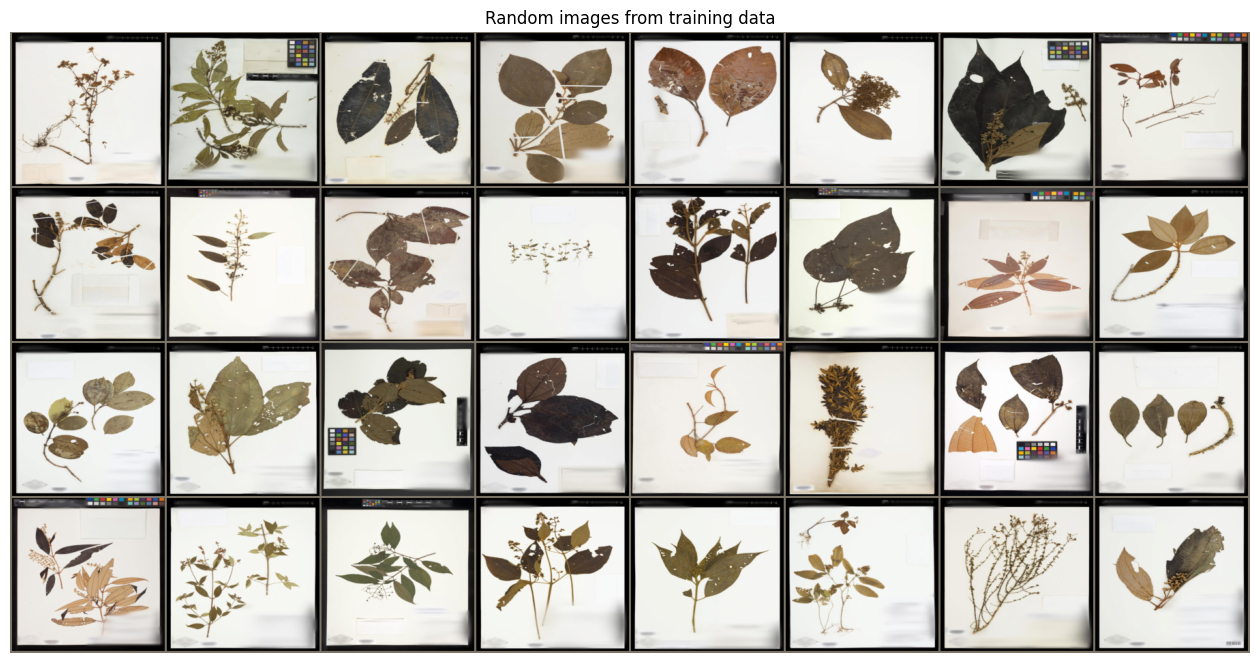

In [ ]:
inputs, targets = next(iter(train_dl))
out = torchvision.utils.make_grid(inputs, padding=3)
plt.figure(figsize=(16, 12))
imshow(out, title='Random images from training data')

# model(CNN)

In [ ]:
class SimpleCNN(nn.Module):

    def __init__(self):
        super(SimpleCNN, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.fc = nn.Linear(56 * 56 * 32, 683)

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)            # (bs, C, H,  W)
        out = out.view(out.size(0), -1)  # (bs, C * H, W)
        out = self.fc(out)
        return out

Now, it's time to create the model and to put it on the GPU.

In [ ]:
model = SimpleCNN()

# transfer model to GPU, if gpu is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)

# Loss Function

<img src="http://www.snrazavi.ir/imgs/loss.png" width="60%"/>

In [ ]:
criterion = nn.CrossEntropyLoss()

<img src="http://www.snrazavi.ir/imgs/cross_entropy_formula.jpg" width="80%"/>

 # Optimization: Minimizing Loss Function
 - Now, he have a loss function which measures how **bad** the parameters are.
- Therefore, we can find **best parameters** by minimizing the loss function.

# Gradient Descent Algorithm

<img src="http://www.snrazavi.ir/imgs/gradient_descent_line_graph.gif" width="100%"/>

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.002, momentum=0.9)

# train

In [ ]:
num_epochs = 10
losses = []
epochs = []

for epoch in range(num_epochs):
    epoch_loss = 0.0
    for i, (inputs, targets) in enumerate(train_dl):
        inputs = inputs.to(device)
        targets = targets.to(device)

        # forward pass
        outputs = model(inputs)

        # loss
        loss = criterion(outputs, targets)
        epoch_loss += loss.item()

        # backward pass
        optimizer.zero_grad()
        loss.backward()

        # update parameters
        optimizer.step()

        # report
        if (i + 1) % 50 == 0:
            print('Epoch [%2d/%2d], Step [%3d/%3d], Loss: %.4f'
                  % (epoch + 1, num_epochs, i + 1, len(train_dl), loss.item()))

    epochs.append(epoch + 1)

    losses.append(epoch_loss / len(train_dl))

Epoch [ 1/10], Step [ 50/1070], Loss: 6.6030
Epoch [ 1/10], Step [100/1070], Loss: 6.4526
Epoch [ 1/10], Step [150/1070], Loss: 6.3981
Epoch [ 1/10], Step [200/1070], Loss: 5.7820
Epoch [ 1/10], Step [250/1070], Loss: 5.7784
Epoch [ 1/10], Step [300/1070], Loss: 6.0574
Epoch [ 1/10], Step [350/1070], Loss: 5.5079
Epoch [ 1/10], Step [400/1070], Loss: 5.5599
Epoch [ 1/10], Step [450/1070], Loss: 5.7293
Epoch [ 1/10], Step [500/1070], Loss: 5.6982
Epoch [ 1/10], Step [550/1070], Loss: 5.3439
Epoch [ 1/10], Step [600/1070], Loss: 5.4887
Epoch [ 1/10], Step [650/1070], Loss: 5.6592
Epoch [ 1/10], Step [700/1070], Loss: 5.5011
Epoch [ 1/10], Step [750/1070], Loss: 5.5072
Epoch [ 1/10], Step [800/1070], Loss: 5.6414
Epoch [ 1/10], Step [850/1070], Loss: 5.5234
Epoch [ 1/10], Step [900/1070], Loss: 5.5754
Epoch [ 1/10], Step [950/1070], Loss: 5.6161
Epoch [ 1/10], Step [1000/1070], Loss: 5.3031
Epoch [ 1/10], Step [1050/1070], Loss: 5.8467
Epoch [ 2/10], Step [ 50/1070], Loss: 5.4564
Epoch [ 

# Draw the graph of the loss function

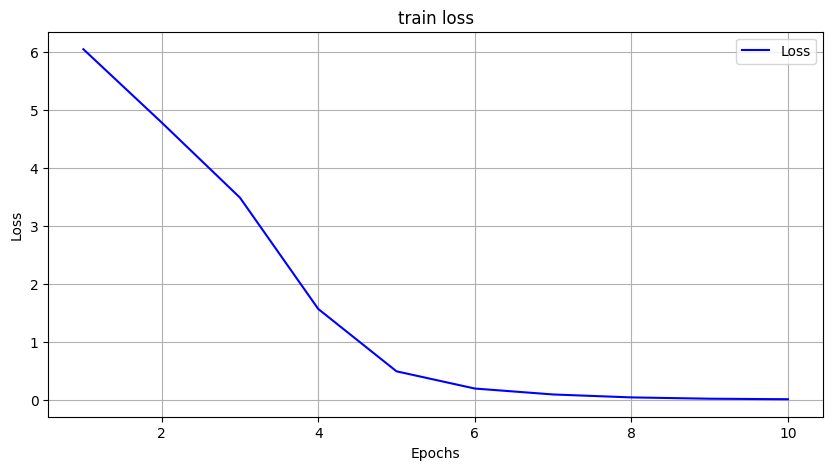

In [ ]:

# loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, losses, label='Loss', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('train loss')
plt.legend()
plt.grid(True)
plt.show()

# Analyze results

### Accuracy on validation data  and loss data

In [ ]:
validation_accuracy = evaluate_model(model, valid_dl, device)
train_accuracy = evaluate_model(model, train_dl, device)

print(f'validation acc: {validation_accuracy:.2f}\ntrain acc: {train_accuracy:.2f}')

validation acc: 15.04
train acc: 99.97


#  Overfit


<div class="alert alert-success">
    <strong>What is OVERFIT? </strong>
    <ul>
        <li>The most important concept in ML!</li>
        <li>Simply, it means that your model is too complex for your problem.</li>
    </ul>
</div>

What we can do about it?

- Regularization
- Dropout
- Data Augmentation
- Transfer Learning

### Transformations

In [ ]:
sz = 224
train_transform = transforms.Compose([
    transforms.Resize((sz, sz)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.1, 0.1, 0.1, 0.01),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((sz, sz)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


train_dataset = datasets.ImageFolder(train_dt, transform=train_transform)
valid_dataset = datasets.ImageFolder(valid_dt, transform=val_transform)

### dataloaders


In [ ]:
batch_size = 32
train_dl = torch.utils.data.DataLoader(train_dataset,
                                       batch_size=batch_size,
                                       shuffle=True,
                                       num_workers=8)

valid_dl = torch.utils.data.DataLoader(valid_dataset,
                                       batch_size=batch_size,
                                       shuffle=False,
                                       num_workers=8)

# Augmented Images

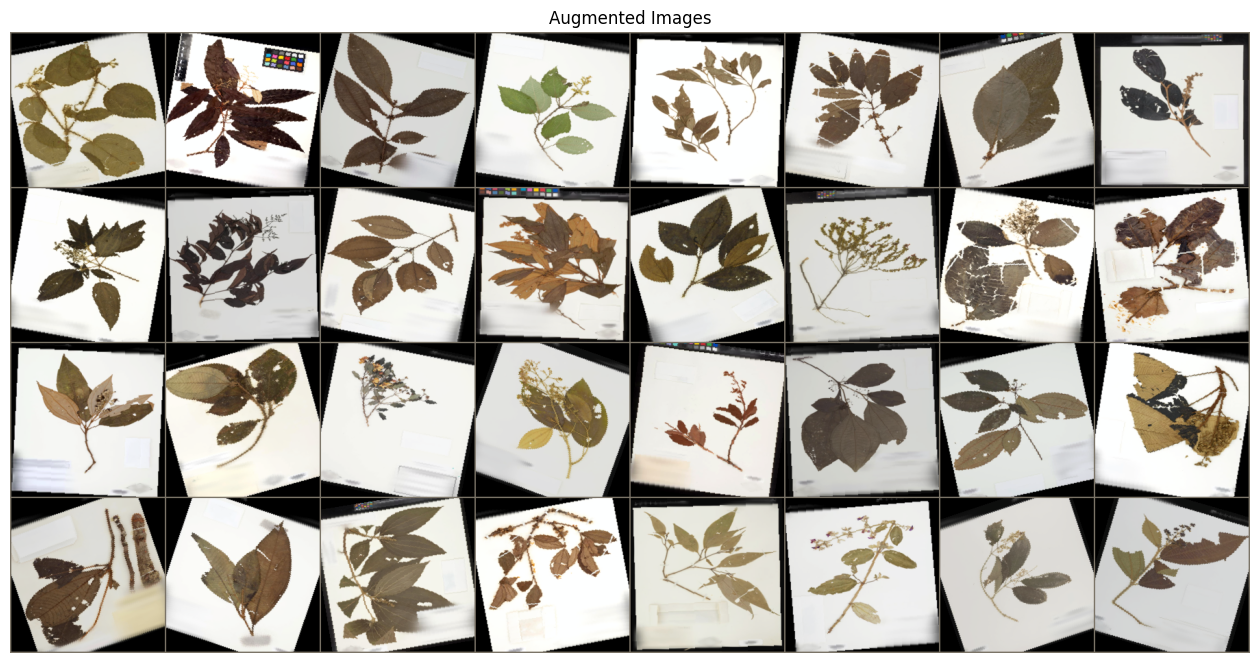

In [ ]:
inputs, targets = next(iter(train_dl))     # Get a batch of training data
out = torchvision.utils.make_grid(inputs)  # Make a grid from batch
plt.figure(figsize=(16., 12.))
imshow(out, title='Augmented Images');

<div class="alert alert-success">
    <h1 align="center">now we want to train our data with</h1>
    <h2 align= 'center'>different optimizer and learning rate</h2>
</div>

# Transfer Learning

- Use a CNN already trained on different data
- Just Train the classifier weights (Last Layer)

# model(resnet50)

In [ ]:
# استفاده از مدل ResNet-50
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 387MB/s]


###Dropout
- we use Dropout(0.3) for SGD

In [ ]:
# Determining the number of classes
num_classes = len(train_dataset.classes)

# Add Dropout to Fully Connected layer
model.fc = nn.Sequential(
    nn.Dropout(0.3),  # Dropout probability 30%
    nn.Linear(num_ftrs, num_classes))

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

criterion = nn.CrossEntropyLoss()

<div class="alert alert-success">
    <h1 align="center">optimizer (SGD), learning rate(0.001)</h1>

</div>

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.001 , momentum = 0.9)

scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5, verbose=True)

### train

In [ ]:
losses = []
epochs = []
def train_model(model, criterion, optimizer, num_epochs):
    corrects = 0
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_dl:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        epoch_loss = running_loss / len(train_dl)
        trn_acc = evaluate_model(model, train_dl, device)
        print(f"Epoch {epoch+1}/{num_epochs}\ntrain Loss: {epoch_loss:.4f}, train acc: {trn_acc:.4f}")

        losses.append(epoch_loss)
        epochs.append(epoch + 1)

        # Model evaluation on validation data
        val_loss = validate_model(model, criterion)
        val_acc = evaluate_model(model, valid_dl, device)
        print(f"Validation Loss: {val_loss:.4f}, Validation Acc: {val_acc:.4f}")

       # Reducing learning rate by scheduler
        scheduler.step(val_loss)

true_labels = []  # To save the authenticity of the tags
predictions = []  # To save predictions


# Model evaluation stage
def validate_model(model, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in valid_dl:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)

            # Add realism tags and predictions to lists
            true_labels.extend(labels.cpu().numpy())
            predictions.extend(predicted.cpu().numpy())

    val_loss /= len(valid_dl)
    return val_loss

In [ ]:
train_model(model, criterion, optimizer, num_epochs=15)
print("Finished Training")

Epoch 1/15
train Loss: 1.6701, train acc: 64.9759
Validation Loss: 1.9024, Validation Acc: 50.8772
Epoch 2/15
train Loss: 1.4966, train acc: 68.2104
Validation Loss: 1.8148, Validation Acc: 54.4606
Epoch 3/15
train Loss: 1.3768, train acc: 68.7071
Validation Loss: 1.7780, Validation Acc: 54.1993
Epoch 4/15
train Loss: 1.2452, train acc: 75.5763
Validation Loss: 1.5771, Validation Acc: 59.5745
Epoch 5/15
train Loss: 1.1403, train acc: 77.7852
Validation Loss: 1.5276, Validation Acc: 60.4330
Epoch 6/15
train Loss: 1.0441, train acc: 79.3075
Validation Loss: 1.4965, Validation Acc: 60.6570
Epoch 7/15
train Loss: 0.9594, train acc: 80.0175
Validation Loss: 1.5590, Validation Acc: 59.3505
Epoch 8/15
train Loss: 0.8775, train acc: 81.2827
Validation Loss: 1.5026, Validation Acc: 61.0302
Epoch 9/15
train Loss: 0.8099, train acc: 82.5829
Validation Loss: 1.5388, Validation Acc: 60.1344
Epoch 10/15
train Loss: 0.7517, train acc: 85.6012
Validation Loss: 1.4348, Validation Acc: 62.0381
Epoch 11/

**Calculation of F_1 Sikore, Recall, Precision**

In [ ]:
# precision
precision = precision_score(true_labels, predictions, average='weighted')
print(f'Precision: {precision:.4f}')

# Recall
recall = recall_score(true_labels, predictions, average='weighted')
print(f'Recall: {recall:.4f}')

# F1-Score
f1 = f1_score(true_labels, predictions, average='weighted')
print(f'F1-Score: {f1:.4f}')

Precision: 0.5961
Recall: 0.6044
F1-Score: 0.5775


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Draw the graph of the loss function

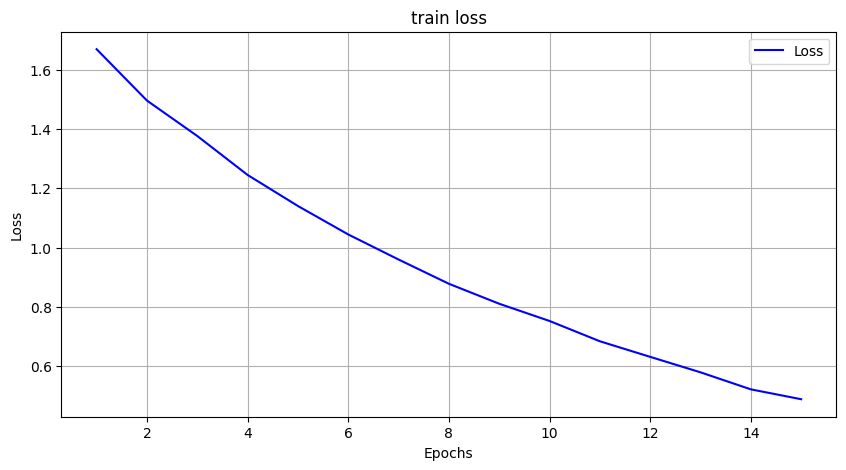

In [ ]:
# loss
plt.figure(figsize=(10, 5))
plt.plot( epochs, losses, label='Loss', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('train loss')
plt.legend()
plt.grid(True)
plt.show()


<div class="alert alert-success">
    <h1 align="center">optimizer (SGD), learning rate = 0.01</h1>
​
</div>

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum = 0.9)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5, verbose=True)


### train

In [ ]:
train_model(model, criterion, optimizer, num_epochs=15)
print("Finished Training")


Epoch 1/15
train Loss: 4.3703, train acc: 25.4785
Validation Loss: 3.6508, Validation Acc: 22.6577
Epoch 2/15
train Loss: 3.0180, train acc: 29.5486
Validation Loss: 3.5133, Validation Acc: 24.7107
Epoch 3/15
train Loss: 2.4668, train acc: 42.8868
Validation Loss: 2.6594, Validation Acc: 36.6181
Epoch 4/15
train Loss: 2.1057, train acc: 49.7736
Validation Loss: 2.4674, Validation Acc: 40.6868
Epoch 5/15
train Loss: 1.8441, train acc: 50.7816
Validation Loss: 2.5009, Validation Acc: 41.0974
Epoch 6/15
train Loss: 1.6548, train acc: 60.3272
Validation Loss: 1.9974, Validation Acc: 49.4588
Epoch 7/15
train Loss: 1.4865, train acc: 67.4536
Validation Loss: 1.7705, Validation Acc: 54.9086
Epoch 8/15
train Loss: 1.3380, train acc: 71.2345
Validation Loss: 1.6429, Validation Acc: 57.1482
Epoch 9/15
train Loss: 1.2079, train acc: 72.8619
Validation Loss: 1.6920, Validation Acc: 56.6629
Epoch 10/15
train Loss: 1.0935, train acc: 73.6362
Validation Loss: 1.6508, Validation Acc: 58.9772
Epoch 11/

### Draw the graph of the loss function

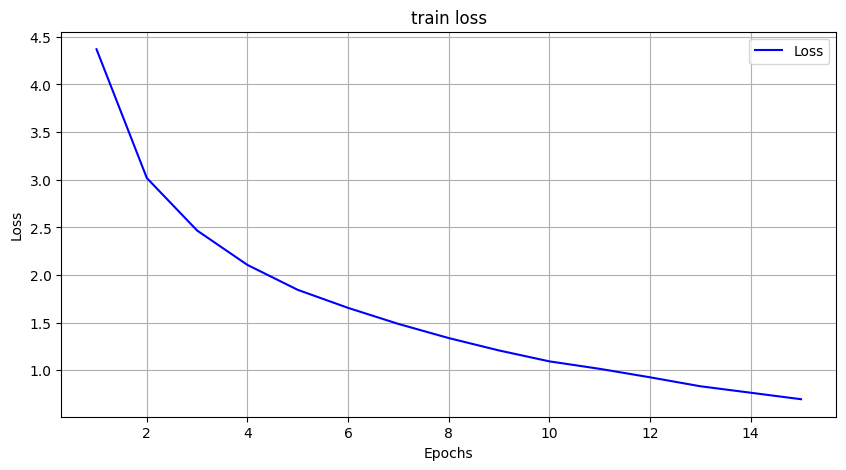

In [ ]:
#  loss
plt.figure(figsize=(10, 5))
plt.plot( epochs, losses, label='Loss', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('train loss')
plt.legend()
plt.grid(True)
plt.show()


<div class="alert alert-success">
    <h1 align="center">optimizer (Adam), learning rate = 0.001</h1>
​
</div>

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5, verbose=True)

### train

In [ ]:
train_model(model, criterion, optimizer, num_epochs=20)
print("Finished Training")


Epoch 1/20
train Loss: 5.8035, train acc: 3.8714
Validation Loss: 5.6502, Validation Acc: 3.4341
Epoch 2/20
train Loss: 5.2012, train acc: 7.9328
Validation Loss: 5.0490, Validation Acc: 6.8682
Epoch 3/20
train Loss: 4.6506, train acc: 9.9459
Validation Loss: 4.8284, Validation Acc: 8.1000
Epoch 4/20
train Loss: 4.1929, train acc: 12.4383
Validation Loss: 4.5186, Validation Acc: 10.7503
Epoch 5/20
train Loss: 3.7984, train acc: 21.5398
Validation Loss: 3.7643, Validation Acc: 19.1116
Epoch 6/20
train Loss: 3.4480, train acc: 27.6961
Validation Loss: 3.4231, Validation Acc: 23.8149
Epoch 7/20
train Loss: 3.0752, train acc: 30.9627
Validation Loss: 3.3144, Validation Acc: 25.5319
Epoch 8/20
train Loss: 2.7026, train acc: 38.8605
Validation Loss: 2.9278, Validation Acc: 32.9227
Epoch 9/20
train Loss: 2.3984, train acc: 37.0431
Validation Loss: 3.0219, Validation Acc: 31.7283
Epoch 10/20
train Loss: 2.1939, train acc: 51.2491
Validation Loss: 2.3045, Validation Acc: 42.6652
Epoch 11/20
tra

### Draw the graph of the loss function

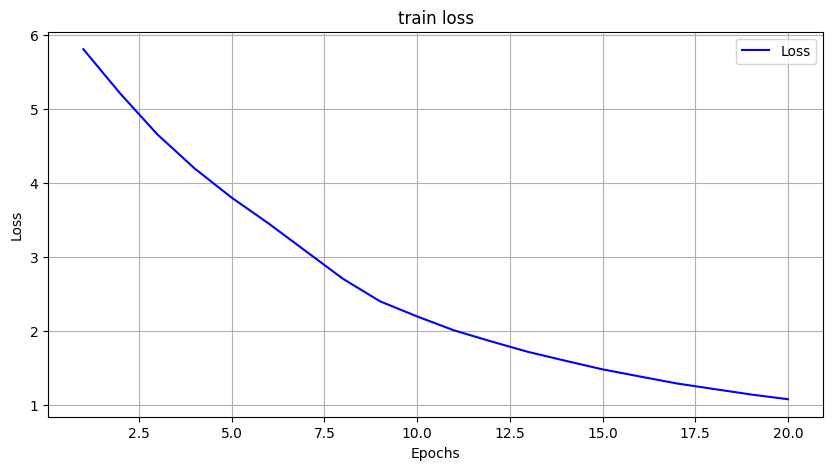

In [ ]:
# loss
plt.figure(figsize=(10, 5))
plt.plot( epochs, losses, label='Loss', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('train loss')
plt.legend()
plt.grid(True)
plt.show()


<div class="alert alert-success">
    <h1 align="center">optimizer (Adam), learning rate = 0.0001</h1>
​
</div>

- here we are the final train and the best one

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5, verbose=True)

### train

In [ ]:
train_model(model, criterion, optimizer, num_epochs=50)
print("Finished Training")


Epoch 1/50
train Loss: 2.7863, train acc: 49.6508
Validation Loss: 2.4315, Validation Acc: 41.1721
Epoch 2/50
train Loss: 2.0919, train acc: 56.6282
Validation Loss: 2.1078, Validation Acc: 47.2191
Epoch 3/50
train Loss: 1.6717, train acc: 64.7714
Validation Loss: 1.8234, Validation Acc: 52.9302
Epoch 4/50
train Loss: 1.3927, train acc: 69.4960
Validation Loss: 1.7063, Validation Acc: 55.7298
Epoch 5/50
train Loss: 1.1998, train acc: 75.3776
Validation Loss: 1.5254, Validation Acc: 60.0597
Epoch 6/50
train Loss: 1.0316, train acc: 79.4887
Validation Loss: 1.4040, Validation Acc: 62.9713
Epoch 7/50
train Loss: 0.9044, train acc: 80.7772
Validation Loss: 1.4296, Validation Acc: 62.0381
Epoch 8/50
train Loss: 0.8015, train acc: 82.6618
Validation Loss: 1.4032, Validation Acc: 63.1206
Epoch 9/50
train Loss: 0.7107, train acc: 85.1658
Validation Loss: 1.3449, Validation Acc: 64.6883
Epoch 10/50
train Loss: 0.6359, train acc: 87.5705
Validation Loss: 1.3074, Validation Acc: 65.3602
Epoch 11/

**Calculation of F_1 Sikore, Recall, Precision**

In [ ]:
# precision
precision = precision_score(true_labels, predictions, average='weighted')
print(f'Precision: {precision:.4f}')

# Recall
recall = recall_score(true_labels, predictions, average='weighted')
print(f'Recall: {recall:.4f}')

# F1-Score
f1 = f1_score(true_labels, predictions, average='weighted')
print(f'F1-Score: {f1:.4f}')

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.6897
Recall: 0.6924
F1-Score: 0.6764


### Draw the graph of the loss function

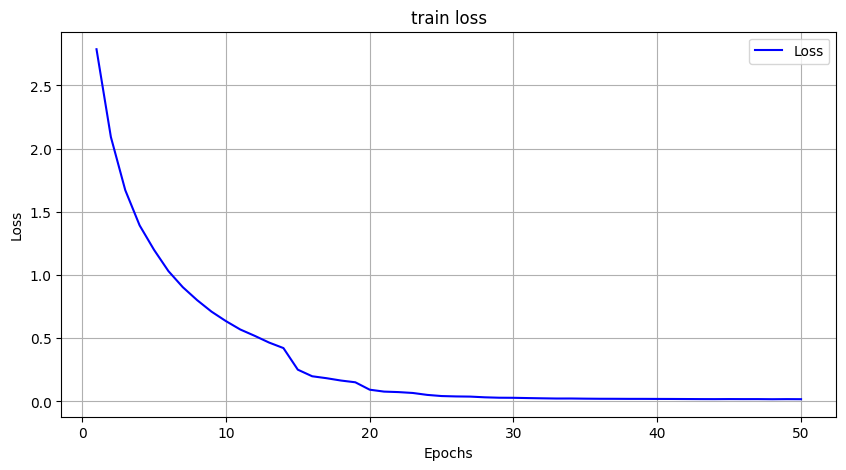

In [ ]:
# loss
plt.figure(figsize=(10, 5))
plt.plot( epochs, losses, label='Loss', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('train loss')
plt.legend()
plt.grid(True)
plt.show()